# Práctica 4
## [Introducción a los sistema inteligentes](https://fagonzalezo.github.io/iis-2022-2/)
### Universidad Nacional de Colombia

### **Funciones Auxiliares**


In [ ]:
import numpy as np
import pylab as pl

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    """
    X: corresponde a las instancias de nuestro conjunto de datos
    pred_fun: es una función que para cada valor de X, me regresa una predicción
    """
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 60)
    y_vals = np.linspace(min_y, max_y, 60)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= -2, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### **Clasificación con funciones lineales**

Dado el siguiente conjunto de datos:

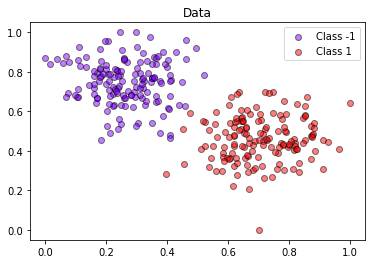

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

X, y = make_blobs(n_samples=300, n_features=2, centers=2, random_state=115)
X = minmax_scale(X)
y = 2 * y - 1 #convert labels to -1, 1
plot_data(X, y)
pl.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Queremos encontrar una función lineal $f(x) = wx+w_0$ con parámetros $w \in \mathbb{R}^2$, $w_0 \in \mathbb{R}$. Formulamos el problema como un problema de optimización:

$$\min_{f\in H}L(f,D)$$

Donde:
* $H$ es el espacio de hipótesis definido como $H=\{f_{w, w_0}(x)=wx+w_0,\forall w\in\mathbb{R}^2 \ and \ w_0\in\mathbb{R}\}$.
* $L$ es la función de pérdida definida como $ L(f, D) =\frac{1}{2}\sum_{(x^{(i)},y^{(i)})\in D} (f(x^{(i)}) - y^{(i)})^2 $.
* $(x^{(i)},y^{(i)})$ es una muestra de entrenamiento donde $y^{(i)}$ es la entrada y $y^{(i)}$ es la etiqueta.
* $D$ corresponde al conjunto de datos de entrenamiento.



In [ ]:
def f(w, x):
    """
     w: numpy array of shape (3,) w[1], w[2] coefficients of x, w[0] independent
        term
     x: numpy array of shape (2,)
    returns:
     a scalar y, with y<0 for class -1, y>=0 for class 1
    """
    a = np.dot(w[1:], x) + w[0]
    return a

In [ ]:
def square_loss(w, x, y):
    '''
     Calculates the loss for a training sample.

     w: numpy array of shape (3,) w[1], w[2] coefficients of x, w[0] independent
        term
     x: numpy array of shape (2,)
     y: scalar
    '''
    return (y - f(w, x)) ** 2 / 2

def batch_loss(loss_fun, w, X, Y):
    '''
     Calculates the loss for a set of samples.

     loss_fun: a function that calculates the loss
     w: numpy array of shape (3,) w[1], w[2] coefficients of x, w[0] independent
        term
     X: numpy array of shape (n, 2) with n the number of samples.
     Y: numpy array of shape (n, ) with n the number of samples.
    '''
    assert(X.shape[0] == Y.shape[0])
    n = X.shape[0]
    tot_loss = 0
    for i in range(n):
        tot_loss += loss_fun(w, X[i], Y[i])
    return tot_loss

Input features: [0.41104796 0.48114158]
True label: -1
Predicted label: -0.010117988942762945
Training loss: 68.34321923967141
Test loss: 29.47517221229679


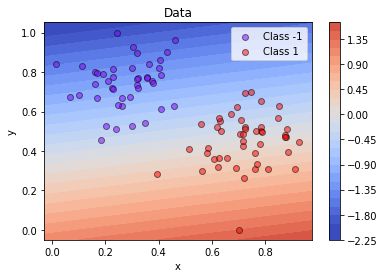

In [ ]:
w = [1, .5, -3]
x = X_train[0]
label = y_train[0]

print('Input features: {}'.format(X[0]))
print('True label: {}'.format(y[0]))
print('Predicted label: {}'.format(f(w, x)))
print(f'Training loss: {batch_loss(square_loss, w, X_train, y_train)}')
print(f'Test loss: {batch_loss(square_loss, w, X_test, y_test)}')
plot_decision_region(X_test, lambda x_1, x_2: f(w, [x_1, x_2]))
plot_data(X_test, y_test)

Utilizaremos descenso de gradiente para minimizar la pérdida. Para ello necesitamos calcular el gradiente de la función de pérdida con respecto a los parámetros.


$$
\begin{aligned} \frac{\partial L(f, D)}{\partial w} & =\frac{1}{2}\sum_{(x^{(i)},y^{(i)})\in D} \frac{\partial (f(x^{(i)}) - y^{(i)})^2}{\partial w}  
\end{aligned}
$$
con
$$
\begin{aligned}
\frac{\partial (f(x^{(i)}) - y^{(i)})^2}{\partial w} & =
\frac{\partial (w_1 x_1^{(i)} + w_2 x_2^{(i)} + w_0 - y^{(i)})^2}{\partial w} \\
& =(f_{w}(x^{(i)})-y^{(i)})\left[\begin{array}{c}
1 \\
x_1^{(i)}\\
x_2^{(i)}\\
\end{array}\right]
\end{aligned}
$$

A continuación, definimos una función para calcular el gradiente:

In [ ]:
def dL_dw(w, x, y):
    '''
     Calculates the gradient of the loss function for one sample.
     w: numpy array of shape (3,) w[1], w[2] coefficients of x, w[0] independent
        term
     x: numpy array of shape (2,)
     y: scalar representing the label
    returns:
     a numpy array of shape (3,) with the gradients for each coefficient
    '''

    x_prime = np.zeros(len(x) + 1)
    x_prime[1:] = x
    x_prime[0] = 1
    return (f(w, x) - y) * x_prime

La siguiente función implementa la optimización por descenso de gradiente:

In [ ]:
def batch_gd(X, Y, epochs, eta, w_ini):
    '''
    Gradient descent optimization
     X: numpy array of shape (n, 2) with n the number of samples.
     Y: numpy array of shape (n, ) with n the number of samples.
     epochs: number of iterations
     eta: learning rate
     w_ini: numpy array of shape (3,) with initial values for w
    Returns:
     w: final values of w
     lossess: list with loss values for each epoch
    '''
    losses = []
    w = w_ini
    n = X.shape[0] # número de ejemplos de entrenamiento
    for i in range(epochs):
        delta = np.zeros(len(w))
        for j in range(n):
            delta += dL_dw(w, X[j], Y[j]) # Vamos sumando el gradiente por cada ejemplo en el conjunto de datos
        w = w - eta * delta # Calculamos el nuevo valor de w
        losses.append(batch_loss(square_loss, w, X, Y)) # Vamos guardando el valor de pérdida para visualizar luego
    return w, losses

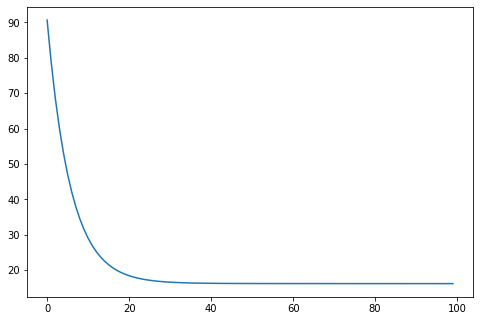

In [ ]:
w, losses = batch_gd(X_train, y_train, 100, 0.005, np.array([0, 0, 0]))
pl.figure(figsize = (8,16/3))
pl.plot(losses)

Input features: [0.41104796 0.48114158]
True label: -1
Predicted label: 0.8430826242533375
Training loss: 16.176473268606866
Test loss: 6.168968768965618


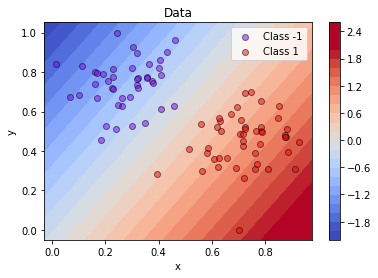

In [ ]:
print('Input features: {}'.format(X[0]))
print('True label: {}'.format(y[0]))
print('Predicted label: {}'.format(f(w, x)))
print(f'Training loss: {batch_loss(square_loss, w, X_train, y_train)}')
print(f'Test loss: {batch_loss(square_loss, w, X_test, y_test)}')
plot_decision_region(X_test, lambda x_1, x_2: f(w, [x_1, x_2]))
plot_data(X_test, y_test)

## 1. Error de entrenamiento y error prueba

Calcule el número (y el porcentaje) de muestras entrenamiento clasificadas incorrectamente. Haga lo mismo con las muestras de prueba.

In [ ]:
def classified(X,Y,w):
  #r = np.array
  errors = 0
  result = []
  for x in X:
    a = 0
    r = f(w,x)
    if r >= 0:
      a=1
    elif r < 0:
      a=0
    result.append(a)
  for i in range(len(Y)):
    if result[i] != Y[i]:
      errors +=1
  total = len(Y)
  percentage = (errors * 100)/total
  return percentage





In [ ]:
classified(X_test, y_test,w)

47.77777777777778

## 2. Nuevo conjunto de datos

Dado el siguiente conjunto de datos:

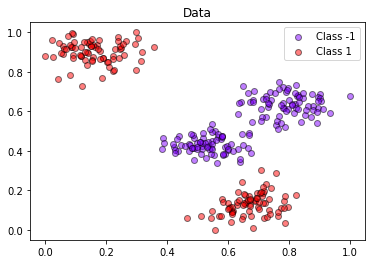

In [ ]:
X, y = make_blobs(n_samples=300, n_features=2, centers=4, random_state=109)
X = minmax_scale(X)
y = 2 * (y % 2) - 1 #convert labels to -1, 1
plot_data(X, y)
pl.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

* Entrene un modelo lineal.
* Grafique los datos con las regiones de decisión para cada clase.
* Calcule el error de entrenamiento y el error de prueba.
* Discuta los resultados.

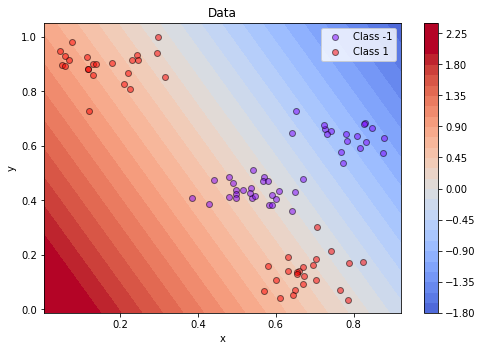

In [ ]:
w, losses = batch_gd(X_train, y_train, 100, 0.006, np.array([0, 0, 0]))
pl.figure(figsize = (8,16/3))
plot_decision_region(X_test, lambda x_1, x_2: f(w, [x_1, x_2]))
plot_data(X_test, y_test)

## 3. Modelo cuadrático
Modifique el código anterior para entrenar un modelo cuadrático
$$
f_w(x)=w_1 x_1^2 + w_2 x_2^2 + w_3 x_1 x_2 + w_4 x_1 + w_5 x_2 + w_0
$$

**Pista:** no hay necesidad de crear nuevas funciones solo crear un nuevo dataset.

* Grafique los datos con las regiones de decisión para cada clase.
* Calcule el error de entrenamiento y el error de prueba.
* Discuta los resultados.

In [ ]:
def newDataSet (x):
  X_new = np.zeros((x.shape[0],5))
  for i in range(X.size):
    X_new[i,0] = x[0]**2
    X_new[i,1] = x[1]**2
    X_new[i,2] = x[1]*x[0]
    X_new[i,3] = x[0]
    X_new[i,4] = x[1]
  return X_new
print(newDataSet(X_train))

[0.4563018  0.00462982]


ValueError: ignored

In [ ]:
def f_new(w, x):
  x_new = newDataSet(x)
  a = np.dot(w[1:], x[0]) + np.dot(w[2:], x[1]) + np.dot(w[3:], x[2]) + np.dot(w[4:], x[3]) + np.dot(w[5:], x[4]) + w[0]
  return a

## 4. Conjunto de datos de círculos

Repita el anterior punto con este nuevo conjunto de datos:

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=300, noise=0.1, factor=0.6, random_state=109)
X = minmax_scale(X)
y = 2 * (y % 2) - 1 #convert labels to -1, 1
plot_data(X, y)
pl.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## 5. Acotando la salida del modelo

Un problema con el modelo lineal original, y también con el cuadrático, es que su salida no está acotada. ¿Se le ocurre alguna forma de acotar la salida del modelo de forma que esté en el rango $[-1,1]$?



# Entrega
La solución a la práctica debe remitirse como un notebook (extensión `ipynb`) al finalizar la clase através del siguiente File Request de Dropbox: https://www.dropbox.com/request/Q5zEZcj4vS8N25SHAoFT. El archivo debe tener el siguiente nombre: `isi-pr4-unalusername.ipynb` donde unalusername corresponde a su nombre de usuario de la cuenta de correo de la universidad. Envíos que no se ciñan a estas instrucciones no serán tenidos en cuenta.